# Distribution Approach
Interferometry tracks the ToF, giving us an intensity distribution over time. Assuming the refractive indices are similar across the entire tissue structure/body, photon total path ($\sum_{i=1}^{T}L_i$; with T being the number of tissue layers) can be a proxy for time. (If the refractive indices are different, we need to calculate the speed of light in each tissue layer/medium separately and then calculate the actual ToF for each photon. Although that approach is tractable in our setup, it's simpler to assume the speed of light remains constant for now.) So, the simulation plots we are interested in are Intensity($<G, A>$) vs. Photon total path($\sum_{i=1}^{T}L_i$)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from inverse_modelling_tfo.tools.name_decoder import decode_extended_filename
from ipywidgets import interact
import ipywidgets as widgets
from tfo_sensitivity.data import load_raw

# Pre-calculated intensity using the regular formula (inner product)
# INTENSITY_DATA_PATH = Path('../data/s_based_intensity_low_conc2.pkl')

# intensity_data = pd.read_pickle(INTENSITY_DATA_PATH)
# intensity_data = intensity_data[(intensity_data['Maternal Wall Thickness'] == maternal_wall_thickness) & (intensity_data['Wave Int'] == wave_int)]

maternal_wall_thickness, uterus_thickness, wave_int = 4, 5, 2
raw_sim_data_path = load_raw(
    maternal_wall_thickness, uterus_thickness, wave_int)
raw_sim_data = pd.read_pickle(raw_sim_data_path)


In [2]:
from inverse_modelling_tfo.tools.s_based_intensity_datagen import MU_MAP_BASE1, MU_MAP_BASE2, get_mu_a
from tfo_sensitivity.calculate_intensity import create_quantized_tof
# Create SDD column!
raw_sim_data['SDD'] = raw_sim_data['X'] - 100


In [3]:
# all_sdd = raw_sim_data['SDD'].unique()
# create_quantized_tof(raw_sim_data, DIGITIZATION_BIN_COUNT)


# def plot_L_distribution(sdd_index):
#     SDD = all_sdd[sdd_index]
#     plt.figure()
#     plt.hist(raw_sim_data[raw_sim_data['SDD'] == SDD]["Total Path"], bins=100)
#     plt.xlabel("Total Path (mm)")
#     plt.ylabel("Count")


# sddSlider = widgets.IntSlider(15, min=0, max=19, step=1)
# interact(plot_L_distribution, sdd_index=sddSlider)


In [12]:
# Mu Map
MATERNAL_Hb = 12.
MATERNAL_SAT = 0.9
FETAL_SAT = 0.225
FETAL_Hb = 0.11
DIGITIZATION_BIN_COUNT = 200

modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
epsilon = get_mu_a(FETAL_SAT, FETAL_Hb, wave_int) / FETAL_Hb
all_sdd = raw_sim_data['SDD'].unique()


def plot_distribution(c: float, sdd_index: int):
    SDD = all_sdd[sdd_index]
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == SDD].copy()
    create_quantized_tof(filtered_photon_data, DIGITIZATION_BIN_COUNT)
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    L = filtered_photon_data['L4 ppath'].to_numpy()
    transformed_L = np.exp(- epsilon * c * L)
    I = G * transformed_L
    filtered_photon_data["Intensity"] = I
    filtered_photon_data["G"] = G
    filtered_photon_data["A"] = transformed_L
    intensity_v_L = filtered_photon_data.groupby("ToF")["Intensity"].sum()
    G_v_L = filtered_photon_data.groupby("ToF")["G"].sum()
    A_v_L = filtered_photon_data.groupby("ToF")["A"].sum()
    plt.figure(figsize=(16, 8))
    # plt.plot(G_v_L * A_v_L / np.sum(G_v_L * A_v_L), label=r'$A \times G$')
    #
    plt.plot(intensity_v_L/np.sum(intensity_v_L), label='Intensity')
    plt.plot(G_v_L / np.sum(G_v_L), label='G Component')
    plt.plot(A_v_L / np.sum(A_v_L), label='A Component')

    # plt.plot(np.log(intensity_v_L), label='Intensity')
    # plt.plot(np.log(G_v_L), label='G Component')
    # plt.plot(np.log(A_v_L), label='A Component')
    # plt.plot(np.log(intensity_v_L) - np.log(G_v_L) - np.log(A_v_L), label='Difference')
    # plt.plot(np.arccos(intensity_v_L/ G_v_L / A_v_L), label='Theta')
    # plt.plot(intensity_v_L/ G_v_L / A_v_L, label='cos(Theta)')

    plt.title("Intensity v. Total Path Length\n(Area Normalized for plotting ease)")
    plt.xlabel("ToF(speed of light/mm)")
    plt.ylabel("Intensity")
    # plt.ylim([0, 0.1])
    # plt.yscale('log')
    print(f'distribution cosine: {np.dot(A_v_L, G_v_L)/(np.linalg.norm(A_v_L)*np.linalg.norm(G_v_L))}')
    print(f'vector cosine: {np.dot(G, transformed_L)/(np.linalg.norm(G)*np.linalg.norm(transformed_L))}')
    plt.legend()


cSlider = widgets.FloatSlider(4., min=0, max=15, step=0.1)
sddSlider = widgets.IntSlider(3, min=0, max=19, step=1)
interact(plot_distribution, c=cSlider, sdd_index=sddSlider)


interactive(children=(FloatSlider(value=4.0, description='c', max=15.0), IntSlider(value=3, description='sdd_i…

<function __main__.plot_distribution(c: float, sdd_index: int)>

__Remark__: There are a bunch of things going on here
1. When c=0, I becomes the G component. This is obvious from the equations. IF the power in the exponent for the A component goes to 0, all elements in the A component become 1. As a result I equals G. $I = G \times A = G$. For this very specific case, (0 absorption), A vs. ToF curve mimics both I and G vs. ToF. A curves gives us the photon count at each ToF bin.
2. The I vs. ToF distribution *cannot* be reconstrcuted by multiplying the A vs. ToF and G vs. ToF distribution together. This also makes sense from the equation. In the intensity case, you multiply then sum the photons at that ToF. In the later case, you sum first to get A and G individually, and then multiply. The order of the operation matters. This should not usually be the same!
3. All the distribution curves look Gaussian with a small positive Skewness(leaning a bit to the left)
4. An interesting phenomena happens when you increase c or SDD. In both cases, the mean shifts to the right, the scale decreases(Which ofcourse it does. In both conditions we receive photons with lower intensities) and the variance increases(i.e., the curves get fatter, I am guessing this corresponds to an increase in variance)
5. These nice smooth distribution curves only appeared after I binned the ToF column. Without the binning/digitizing, the distributions do not resemble any recognizable shape. Also, the kurtosis becomes more prominent when I increase the bincount.
6. Each individual ToF point can be broken up in the same way as the [Vector_Aprroach](/notebooks/vector_approach.ipynb)! Giving rise to similar representations at each individual point. This can similarly be broken up into $|A||G|cos(\theta )$ with a photon count at the beginning corresponding to that specific ToF.(Again photons different combinations of L1, L2, ...LN can add up to the same sum, leading to the same ToF. It's very difficult to relate ToF distribution to individual medium photon path distribution)
7. Plotting the cosine at each ToF bin shows us some interesting properties! For example, the cosine shifts from 0 to 1 as ToF goes from 0 to max ToF. But this change is not gradual. Rather there is a sudden, and very sharp shift. (It looks a lot like a shifted sigmoid). Also, the cosine does not seem rely on c. But the point of this sudden shift depends on SDD. Let's call it the 'critical point'. It shifts right as we increase SDD. I have no idea how to explain this behaviour. (So for changing c, the values change ever so slightly, but its not at all significant and you can barely notice anything. This also serves to prove that there is no bug in the code, that the cosine the calculations for c does indeed change with c but the values do not)
8. The cosine curve has sharp changes but the log(cos(theta)) has a very smooth change. Which I guess makes sense. (Is also probably easier to work with!)

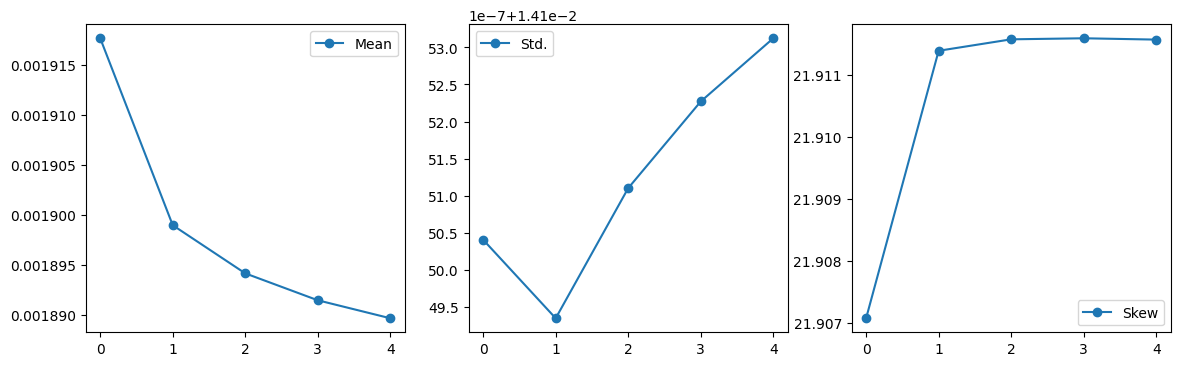

In [5]:
import scipy
all_mean = []
all_skew = []
all_std = []
all_c = np.arange(0., 5., 1.)
SDD_INDEX = 1

MATERNAL_Hb = 5.
MATERNAL_SAT = 1.0
FETAL_SAT = 0.225

modified_mu_map = MU_MAP_BASE1.copy() if wave_int == 1 else MU_MAP_BASE2
modified_mu_map[1] = get_mu_a(MATERNAL_SAT, MATERNAL_Hb, wave_int)
epsilon = get_mu_a(FETAL_SAT, 1, wave_int) 
all_sdd = raw_sim_data['SDD'].unique()

for c in all_c:
    SDD = all_sdd[SDD_INDEX]
    filtered_photon_data = raw_sim_data[raw_sim_data['SDD'] == SDD].copy()
    create_quantized_tof(filtered_photon_data, DIGITIZATION_BIN_COUNT)
    G = filtered_photon_data[['L1 ppath', 'L2 ppath', 'L3 ppath']].to_numpy()
    for i in range(1, 4):
        G[:, i - 1] = np.exp(-modified_mu_map[i] * G[:, i - 1])
    G = np.prod(G, axis=1)
    L = filtered_photon_data['L4 ppath'].to_numpy()
    transformed_L = np.exp(- epsilon * c * L)
    I = G * transformed_L
    mean = np.mean(I)
    skew = scipy.stats.skew(I)
    std = np.std(I)

    all_mean.append(mean)
    all_std.append(std)
    all_skew.append(skew)

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(all_c, all_mean, 'o-', label='Mean',)
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(all_c, all_std, 'o-', label='Std.')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(all_c, all_skew, 'o-', label='Skew')
plt.legend()
plt.show()
